In [412]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#for model building
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
#for feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#for assumption checking
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
#for model validation
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
#for cross validation
from sklearn.model_selection import KFold,cross_val_score,LeaveOneOut,train_test_split
#for hyper parameter tuning
from sklearn.model_selection import GridSearchCV
#for regularization
from sklearn.linear_model import ElasticNet,Lasso,Ridge
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [413]:
df = pd.read_csv('master.csv')
df.head(3)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,15,66,24,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,15,66,24,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,15,66,24,900",796,Generation X


In [414]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [415]:
df.shape
# the data set has 27820 rows and 12 columns

(27820, 12)

In [416]:
df.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

In [417]:
df.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [418]:
df.isnull().sum()/len(df)*100
# we can see that HDI for year has 70% of Null values, so we need to drop it

country                0.000000
year                   0.000000
sex                    0.000000
age                    0.000000
suicides_no            0.000000
population             0.000000
suicides/100k pop      0.000000
country-year           0.000000
HDI for year          69.935298
 gdp_for_year ($)      0.000000
gdp_per_capita ($)     0.000000
generation             0.000000
dtype: float64

<AxesSubplot:>

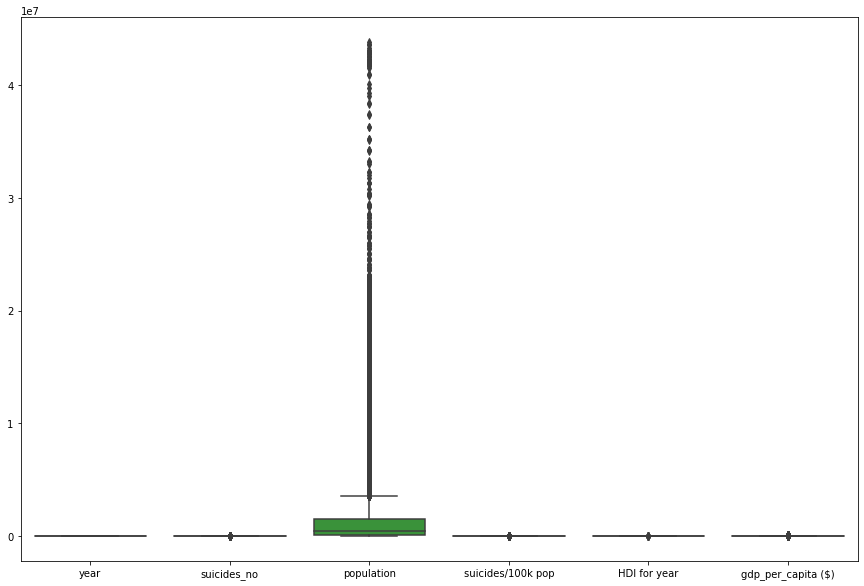

In [419]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df)

In [420]:
df_num = df.select_dtypes(include=np.number)

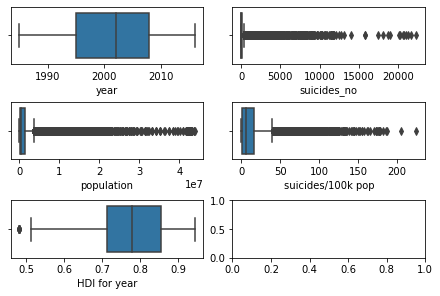

In [421]:
fig, axes = plt.subplots(3,2,constrained_layout=True)
for i ,sp in zip(range(5),axes.flatten()):
    sns.boxplot(df_num.iloc[:,i],ax=sp)
plt.show()

In [422]:
# there are outliers present in all the columns and we are not treating them as it will lead to data manupulation.

In [423]:
df[' gdp_for_year ($) '].value_counts() # it is a redundant column 

2,15,66,24,900       12
96,04,56,45,026      12
27,11,66,35,600      12
29,44,02,87,600      12
34,68,62,24,300      12
                     ..
3,90,79,99,91,147    10
51,33,85,24,831      10
1,25,81,66,40,421    10
10,54,61,35,160      10
11,18,34,58,131      10
Name:  gdp_for_year ($) , Length: 2321, dtype: int64

In [424]:
# so we drop the HDI for year column for our analysis
# we dont need columns 'country-year' as it is a dublicate column and ' gdp_for_year ($) ' as it is not required
# we dont need Generation also is age column also represents the same data.
df.drop(['country-year','HDI for year',' gdp_for_year ($) ','generation'],axis = 1,inplace=True)

In [425]:
df.tail()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,2309
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,2309
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,2309
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,2309
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,2309


In [426]:
df['age'].value_counts()

15-24 years    4642
35-54 years    4642
75+ years      4642
25-34 years    4642
55-74 years    4642
5-14 years     4610
Name: age, dtype: int64

In [427]:
a=df['age'].value_counts().index
a

Index(['15-24 years', '35-54 years', '75+ years', '25-34 years', '55-74 years',
       '5-14 years'],
      dtype='object')

In [428]:
# as age is a object column and we rename the age values with appropriate names
df['age'].replace(a,['young_adults','middle age','senior citizens','adults','old age','kids'],inplace=True)

# we are replacing  
# 5- 14 kids
# 15- 24 young adults
# 25- 34 adults
# 34- 54 middle age
# 55-74 old age
# 75+ senior citizens

In [429]:
df['age'].value_counts().index

Index(['young_adults', 'middle age', 'senior citizens', 'adults', 'old age',
       'kids'],
      dtype='object')

In [430]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
0,Albania,1987,male,young_adults,21,312900,6.71,796
1,Albania,1987,male,middle age,16,308000,5.19,796
2,Albania,1987,female,young_adults,14,289700,4.83,796
3,Albania,1987,male,senior citizens,1,21800,4.59,796
4,Albania,1987,male,adults,9,274300,3.28,796


In [431]:
# checking for dublicate values
df.duplicated().value_counts()
# there are no dublicate values

False    27820
dtype: int64

In [432]:
df.describe() # numerical columns description

,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,126352.000000


In [433]:
df.describe(include='object') # categorical columns description

,country,sex,age
count,27820,27820,27820
unique,101,2,6
top,Mauritius,male,young_adults
freq,382,13910,4642


In [434]:
# Analysis

<AxesSubplot:xlabel='year'>

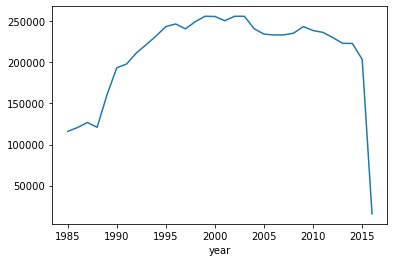

In [435]:
df['suicides_no'].groupby(df.year).sum().plot(kind='line')

In [436]:
# we can observe that no. of suicides increased around 1990 and it stayed high with a slight dip in 2005

<AxesSubplot:xlabel='suicides_no', ylabel='sex'>

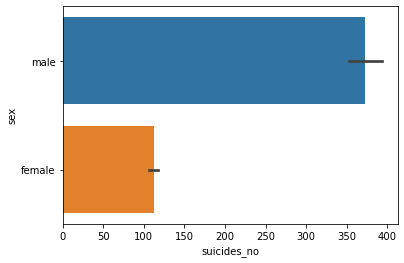

In [437]:
sns.barplot(df['suicides_no'],df['sex'])

In [438]:
# we can observe that the number of suicides is more in males than females

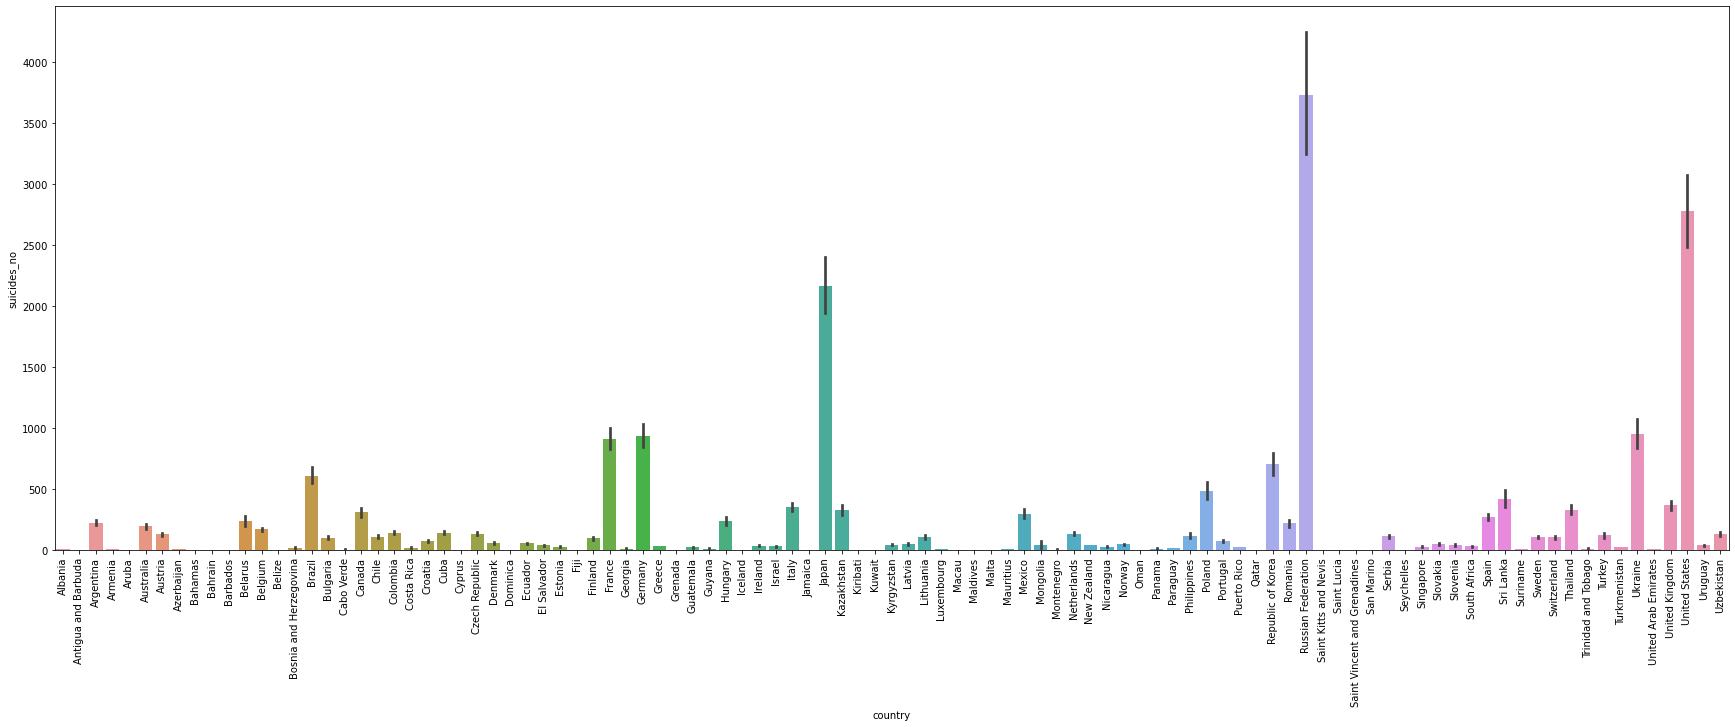

In [439]:
plt.figure(figsize=(30,10))
sns.barplot(df['country'],df['suicides_no'])
plt.xticks(rotation=90)
plt.show()

In [440]:
# top 5 countries based on no of suicides
df['suicides_no'].groupby(df.country).sum().sort_values(ascending=False).head()

country
Russian Federation    1209742
United States         1034013
Japan                  806902
France                 329127
Ukraine                319950
Name: suicides_no, dtype: int64

In [441]:
# we can observe that Russian Federation has the highest no of suicides followed by United States and Japan, France

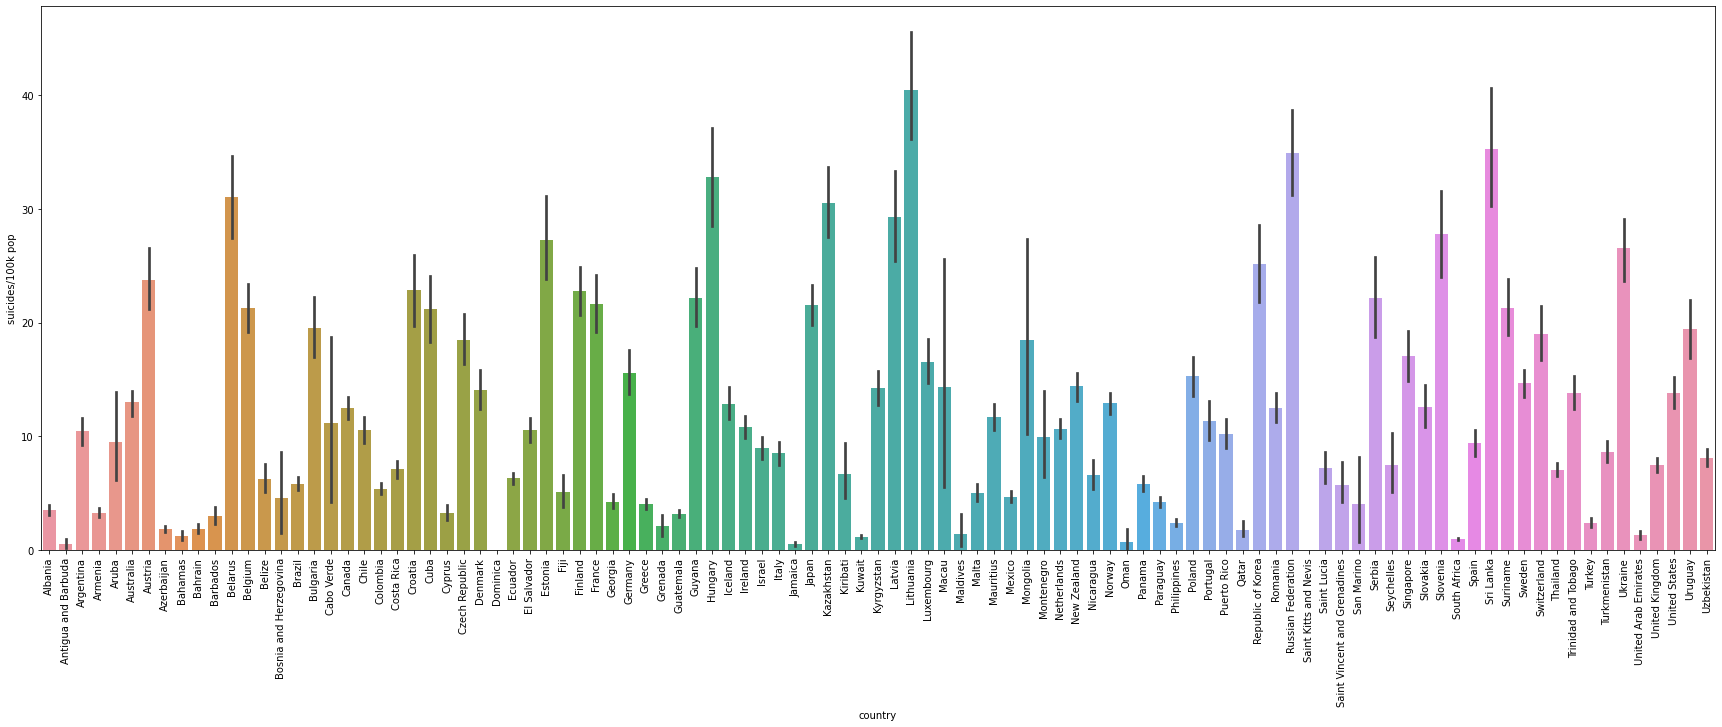

In [442]:
plt.figure(figsize=(30,10))
sns.barplot(df['country'],df['suicides/100k pop'])
plt.xticks(rotation=90)
plt.show()

In [443]:
# top 5 countries with suicides/100k pop
df.groupby('country')['suicides/100k pop'].mean().sort_values(ascending=False).head()

country
Lithuania             40.415573
Sri Lanka             35.295152
Russian Federation    34.892377
Hungary               32.761516
Belarus               31.075913
Name: suicides/100k pop, dtype: float64

In [444]:
# we can observe that lithuania is the top country with respect to suicides/100k pop, followed by srilanka,russian 

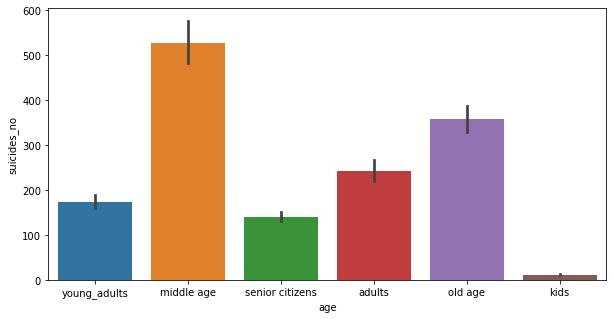

In [445]:
plt.figure(figsize=(10,5))
sns.barplot(df['age'],df['suicides_no'])
plt.show()
# 5- 14 kids
# 15- 24 young adults
# 25- 34 adults
# 34- 54 middle age
# 55-74 old age
# 75+ senior citizens

In [446]:
# we ccan observe that middle_age(34- 54 years) has the highest no of suicides followed by old_age(55-74 years)

In [447]:
df.tail()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
27815,Uzbekistan,2014,female,middle age,107,3620833,2.96,2309
27816,Uzbekistan,2014,female,senior citizens,9,348465,2.58,2309
27817,Uzbekistan,2014,male,kids,60,2762158,2.17,2309
27818,Uzbekistan,2014,female,kids,44,2631600,1.67,2309
27819,Uzbekistan,2014,female,old age,21,1438935,1.46,2309


<AxesSubplot:xlabel='gdp_per_capita ($)', ylabel='suicides/100k pop'>

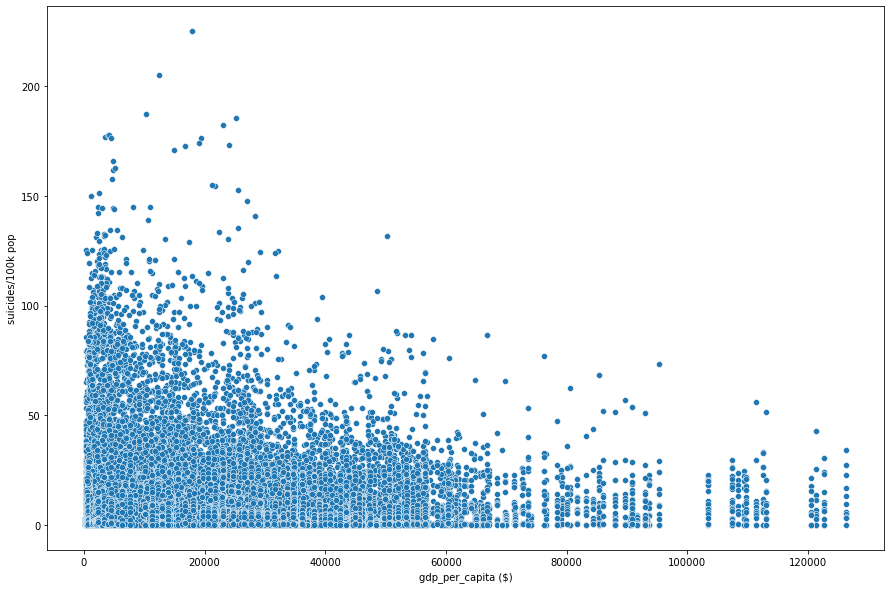

In [448]:
plt.figure(figsize=(15,10))
sns.scatterplot(df['gdp_per_capita ($)'],df['suicides/100k pop'])

In [449]:
# the GDP per capita and the Suicide per 100K have a strong negative correlation. 
# This means that when the GDP per capita decreases,the suicide rate increases.
# It can be obsrved from the above scatter plot. 

In [450]:
df.corr()

,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
year,1.000000,-0.004546,0.008850,-0.039037,0.339134
suicides_no,-0.004546,1.000000,0.616162,0.306604,0.061330
population,0.008850,0.616162,1.000000,0.008285,0.081510
suicides/100k pop,-0.039037,0.306604,0.008285,1.000000,0.001785
gdp_per_capita ($),0.339134,0.061330,0.081510,0.001785,1.000000


<AxesSubplot:>

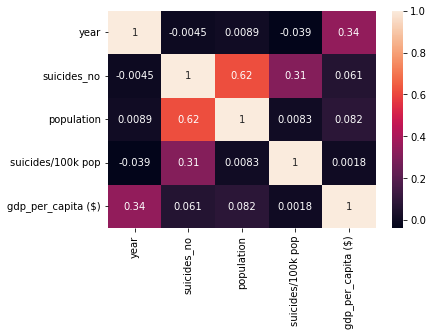

In [451]:
sns.heatmap(df.corr(),annot=True)

In [452]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
0,Albania,1987,male,young_adults,21,312900,6.71,796
1,Albania,1987,male,middle age,16,308000,5.19,796
2,Albania,1987,female,young_adults,14,289700,4.83,796
3,Albania,1987,male,senior citizens,1,21800,4.59,796
4,Albania,1987,male,adults,9,274300,3.28,796


In [453]:
df['country'].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

In [454]:
# we are binning the countries according to their continents

In [455]:
df.country.replace(['Azerbaijan','Bahrain','Belarus','Belgium','Georgia','Israel','Japan','Kazakhstan','Kuwait','Kyrgyzstan','Macau',
        'Maldives','Mongolia','Oman','Uzbekistan','United Arab Emirates','Turkmenistan','Thailand','Sri Lanka','Singapore',
        'Republic of Korea','Qatar','Philippines'],'asia',inplace=True)
df.country.replace(['United States','Saint Vincent and Grenadines','Saint Kitts and Nevis','Qatar','Puerto Rico',
                'Antigua and Barbuda','Bahamas','Barbados','Belize','Canada','Costa Rica','Cuba','Dominica','El Salvador',
                'Grenada','Guatemala','Jamaica','Mexico','Nicaragua','Panama'],'northamerica',inplace=True)
df.country.replace(['Uruguay','Trinidad and Tobago','Suriname','Saint Lucia','Argentina','Aruba','Brazil','Chile','Colombia',
                'Ecuador','Guyana','Norway','Paraguay'],'southamerica',inplace=True)
df.country.replace(['South Africa','Seychelles','Cabo Verde','Mauritius'],'africa',inplace=True)
df.country.replace(['United Kingdom','Ukraine','Turkey','Switzerland','Sweden','Spain','Slovenia','Slovakia','Serbia','San Marino',
          'Romania','Portugal','Poland','Albania','Armenia','Austria','Bosnia and Herzegovina','Bulgaria','Croatia',
          'Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland',
          'Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta','Montenegro','Netherlands'],'europe',inplace=True)
df.country.replace(['Australia','Fiji','Kiribati','New Zealand'],'australia',inplace=True)

In [456]:
df['country'].unique()
# checking values in countries column

array(['europe', 'northamerica', 'southamerica', 'australia', 'asia',
       'africa', 'Russian Federation'], dtype=object)

In [457]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,gdp_per_capita ($)
0,europe,1987,male,young_adults,21,312900,6.71,796
1,europe,1987,male,middle age,16,308000,5.19,796
2,europe,1987,female,young_adults,14,289700,4.83,796
3,europe,1987,male,senior citizens,1,21800,4.59,796
4,europe,1987,male,adults,9,274300,3.28,796


In [458]:
df.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
gdp_per_capita ($)      int64
dtype: object

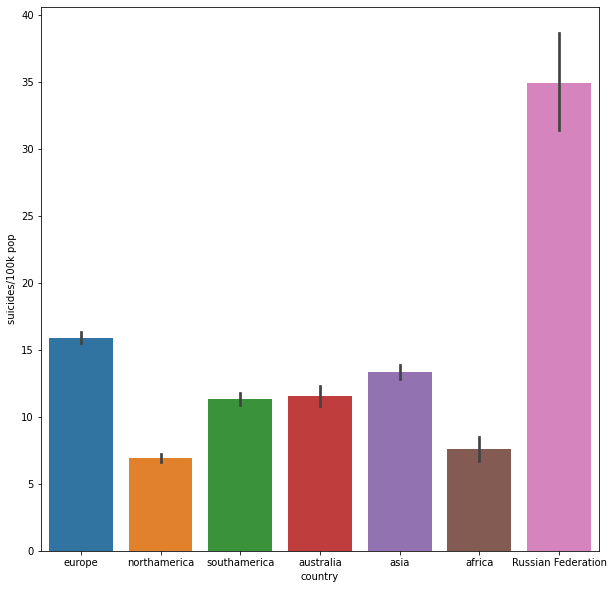

In [459]:
plt.figure(figsize=(10,10))
sns.barplot(df['country'],df['suicides/100k pop'])
plt.show()
# we plot a bocplot of regions with sucide per 100k

In [460]:
# encoding of categorical column using get_dummies
df=pd.get_dummies(data=df,columns=['country','sex','age'],drop_first=True)

In [461]:
df.head()

,year,suicides_no,population,suicides/100k pop,gdp_per_capita ($),country_africa,country_asia,country_australia,country_europe,country_northamerica,country_southamerica,sex_male,age_kids,age_middle age,age_old age,age_senior citizens,age_young_adults
0,1987,21,312900,6.71,796,0,0,0,1,0,0,1,0,0,0,0,1
1,1987,16,308000,5.19,796,0,0,0,1,0,0,1,0,1,0,0,0
2,1987,14,289700,4.83,796,0,0,0,1,0,0,0,0,0,0,0,1
3,1987,1,21800,4.59,796,0,0,0,1,0,0,1,0,0,0,1,0
4,1987,9,274300,3.28,796,0,0,0,1,0,0,1,0,0,0,0,0


In [462]:
x=df.drop('suicides/100k pop',axis=1)  # we separate the x(independent) and y(dependent) columns 
y=df['suicides/100k pop']
x=sm.add_constant(x)   

In [463]:
# we split the data into train and test in 70:30 ratio
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=.3,random_state=1)

In [464]:
# we build a base model using ols 
model=sm.OLS(ytrain,xtrain).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides/100k pop   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     795.4
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        22:05:20   Log-Likelihood:                -80037.
No. Observations:               19474   AIC:                         1.601e+05
Df Residuals:                   19457   BIC:                         1.602e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  185.4768     26.675      6.953      0.000     133.193     237.761
year                    -0.0867      0.013     -6.512      0.000      -0.113      -0.061
suicides_no              0.0066      0.000     40.030      0.000       0.006       0.007
population           -7.092e-07   3.56e-08    -19.902      0.000   -7.79e-07   -6.39e-07
gdp_per_capita ($)   -3.228e-05   6.24e-06     -5.176      0.000   -4.45e-05   -2.01e-05
country_africa         -11.2612      1.240     -9.083      0.000     -13.691      -8.831
country_asia            -5.7822      1.100     -5.257      0.000      -7.938      -3.626
country_australia       -7.5014      1.228     -6.108      0.000      -9.908      -5.094
country_europe          -2.9931      1.097     -2.728      0.006      -5.144      -0.842
country_northamerica   -12.1146      1.100    -11.012      0.000     -14.271      -9.958
country_southamerica    -6.8947      1.114     -6.190      0.000      -9.078      -4.711
sex_male                13.1132      0.216     60.687      0.000      12.690      13.537
age_kids                -9.9216      0.370    -26.841      0.000     -10.646      -9.197
age_middle age           1.8767      0.367      5.110      0.000       1.157       2.597
age_old age              3.2784      0.368      8.920      0.000       2.558       3.999
age_senior citizens     11.6428      0.367     31.696      0.000      10.923      12.363
age_young_adults        -2.5943      0.367     -7.073      0.000      -3.313      -1.875
==============================================================================
Omnibus:                    12117.557   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           214161.089
Skew:                           2.694   Prob(JB):                         0.00
Kurtosis:                      18.327   Cond. No.                     1.08e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [470]:
# we can observe that all the columns are significant 

In [471]:
xtrain.iloc[:,1:5].head() 
# we separate the numerical columns from the dataset

,year,suicides_no,population,gdp_per_capita ($)
5473,2002,101,2055488,4866
3737,2009,34,646252,47630
17600,1997,5,115700,19041
25259,2012,222,5145957,6584
27529,2013,15,255905,18179


In [472]:
# Scalling
# We do MinMax scalling
from sklearn.preprocessing import MinMaxScaler
MM=MinMaxScaler()
xtrain.iloc[:,1:5]=MM.fit_transform(xtrain.iloc[:,1:5])
xtest.iloc[:,1:5]=MM.transform(xtest.iloc[:,1:5])

In [473]:
xtrain.head()

,const,year,suicides_no,population,gdp_per_capita ($),country_africa,country_asia,country_australia,country_europe,country_northamerica,country_southamerica,sex_male,age_kids,age_middle age,age_old age,age_senior citizens,age_young_adults
5473,1.0,0.548387,0.004521,0.046917,0.036598,0,0,0,0,0,1,0,0,1,0,0,0
3737,1.0,0.774194,0.001522,0.014746,0.375723,0,1,0,0,0,0,0,0,0,0,0,1
17600,1.0,0.387097,0.000224,0.002635,0.149008,0,0,1,0,0,0,0,0,0,0,1,0
25259,1.0,0.870968,0.009938,0.117468,0.050222,0,1,0,0,0,0,0,0,0,1,0,0
27529,1.0,0.903226,0.000672,0.005835,0.142172,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
# Transformation

In [474]:
y.skew() # we observe the skewness of the target variable

2.963414476605633

<AxesSubplot:xlabel='suicides/100k pop', ylabel='Density'>

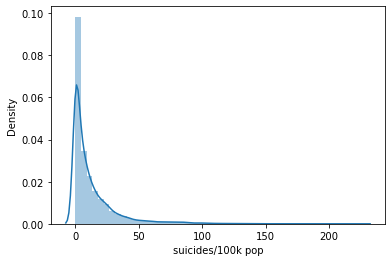

In [475]:
sns.distplot(y) # we plot a distplot of target variable

In [476]:
np.sqrt(y).skew() # we do square root transformation
# we observe that the skewness has reduced after transformation

0.9500270544066147

<AxesSubplot:xlabel='suicides/100k pop', ylabel='Density'>

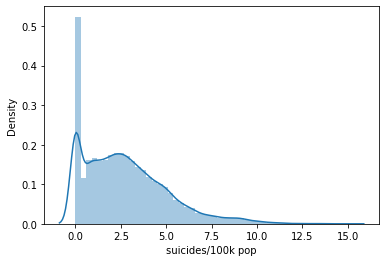

In [477]:
sns.distplot(np.sqrt(y)) # we plot a distplot of the transformed target variable
# after transformation the target variable has achieved is near normal distribution.

In [478]:
# sqrt transformation of the split data
ytrain=np.sqrt(ytrain)
ytest=np.sqrt(ytest)

In [479]:
# we fit the final model using the transformed and scalled data
fmodel=sm.OLS(ytrain,xtrain).fit()
fmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides/100k pop   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     1136.
Date:                Thu, 05 May 2022   Prob (F-statistic):               0.00
Time:                        22:05:21   Log-Likelihood:                -37215.
No. Observations:               19474   AIC:                         7.446e+04
Df Residuals:                   19457   BIC:                         7.460e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.8215      0.126     22.460      0.000       2.575       3.068
year                    -0.3774      0.046     -8.246      0.000      -0.467      -0.288
suicides_no             13.6204      0.408     33.365      0.000      12.820      14.421
population              -1.5404      0.173     -8.896      0.000      -1.880      -1.201
gdp_per_capita ($)       0.0456      0.087      0.522      0.602      -0.125       0.217
country_africa          -1.4096      0.138    -10.250      0.000      -1.679      -1.140
country_asia            -0.5650      0.122     -4.630      0.000      -0.804      -0.326
country_australia       -0.6032      0.136     -4.428      0.000      -0.870      -0.336
country_europe          -0.1763      0.122     -1.449      0.147      -0.415       0.062
country_northamerica    -1.5806      0.122    -12.952      0.000      -1.820      -1.341
country_southamerica    -0.5686      0.124     -4.602      0.000      -0.811      -0.326
sex_male                 1.7109      0.024     71.380      0.000       1.664       1.758
age_kids                -2.2167      0.041    -54.062      0.000      -2.297      -2.136
age_middle age           0.2113      0.041      5.188      0.000       0.131       0.291
age_old age              0.3451      0.041      8.465      0.000       0.265       0.425
age_senior citizens      0.9314      0.041     22.860      0.000       0.852       1.011
age_young_adults        -0.3237      0.041     -7.956      0.000      -0.403      -0.244
==============================================================================
Omnibus:                     1116.161   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2872.865
Skew:                           0.329   Prob(JB):                         0.00
Kurtosis:                       4.763   Cond. No.                         53.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [482]:
# after transformation and scalling the model performance has improved